## TOPIC MODELLING AND SELF ORGANIZING MAPS in R

This is mostly identical to the python `topic_SOMs.ipynb` but in R.

In [1]:
library(RcppCNPy)
library(kohonen)

## Read the topic matrix from numpy
topic.mtx <- npyLoad("data_processed/document_topics_mtx.npy")

# Note that here we have to scale the matrix before passing it to the SOM. 
# Such scaling happens within the SOMPY package in python
X <- scale(topic.mtx)

# in R som and xyf are just wrap-ups of supersom
# Let's start with a 30x30 map, like in python
som.grid <- somgrid(xdim = 30, ydim=30, topo="hexagonal")
som.model <- supersom(
    X,
    grid=som.grid,
    rlen=100,
    alpha=c(0.05,0.01),
    keep.data = TRUE)

the `kohonen` package in R comes with a series of plotting utilities. 

Let's have a look to the counts. One should always aim to have a few counts per node. 

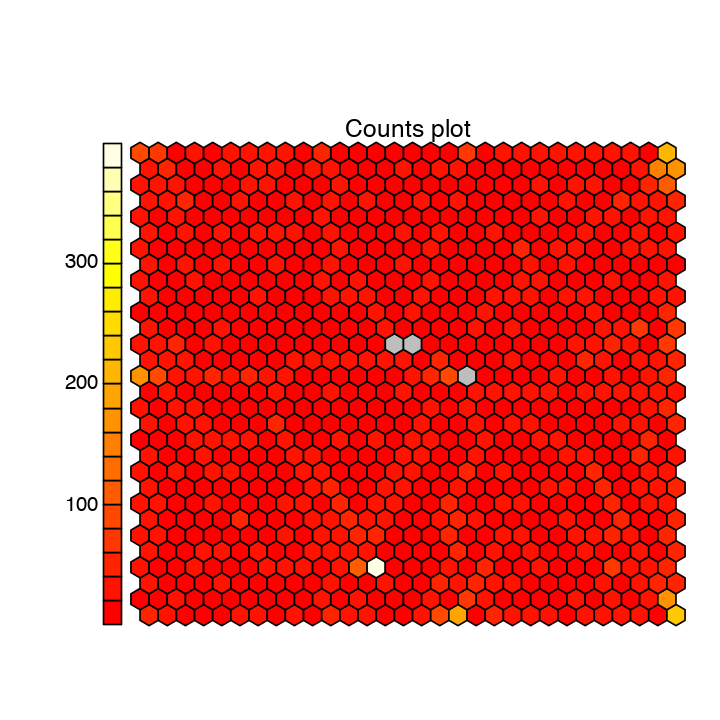

In [2]:
## let's visualize the SOM counts
library(repr)
options(repr.plot.width=6, repr.plot.height=6)
plot(som.model, type="count", heatkeywidth = 1, shape="straight")

Here we also see the boundary effects I mentioned in the companion python notebook. Also, we see there is a small number of empty nodes (colored in grey). We can simply move along, or perhaps, just to change something with respect to the python notebook, use a smaller number of nodes:

In [3]:
som.grid <- somgrid(xdim = 20, ydim=20, topo="hexagonal")
som.model <- supersom(
    X,
    grid=som.grid,
    rlen=100,
    alpha=c(0.05,0.01),
    keep.data = TRUE)

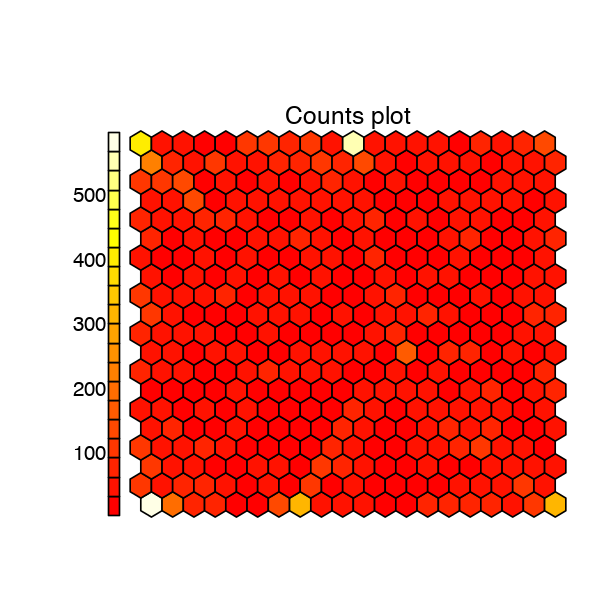

In [4]:
options(repr.plot.width=5, repr.plot.height=5)
plot(som.model, type="count", heatkeywidth = 0.5, shape="straight")

Ok, no empty neurons. If you run this two times you will probably find a couple of 'dead neurons". Anyway, let's move one and visualize the maps per topic

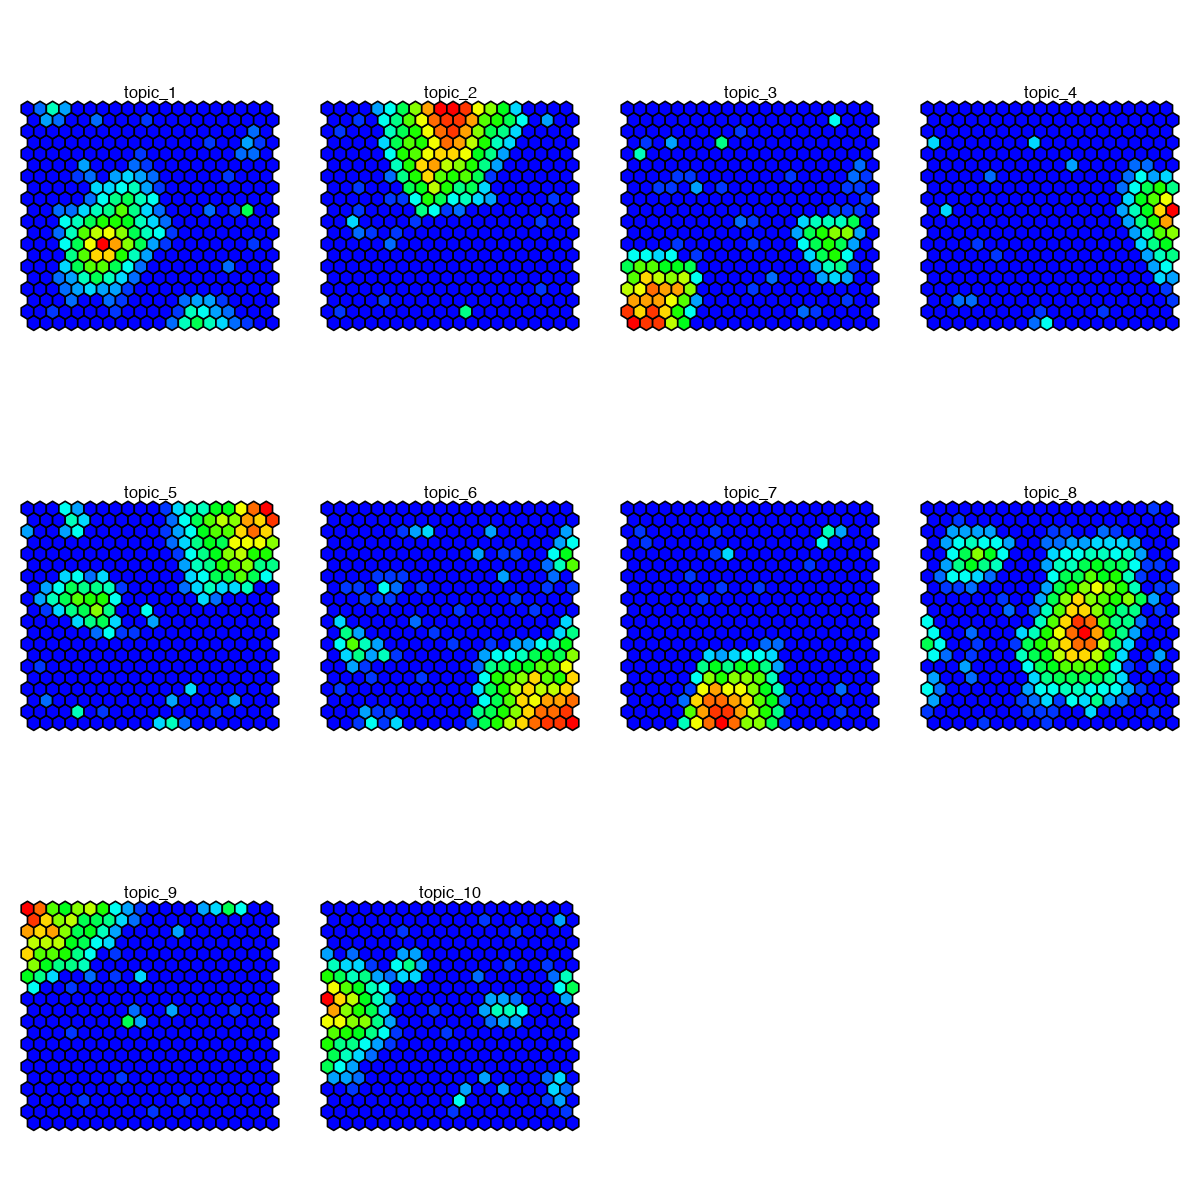

In [5]:
options(repr.plot.width=10, repr.plot.height=10)
coolBlueHotRed <- function(n, alpha = 1) {rainbow(n, end=4/6, alpha=alpha)[n:1]}
par(mfrow=c(3,4))
for (i in 1:10)
{
topic <- aggregate(as.numeric(topic.mtx[,i]),
                    by=list(som.model$unit.classif),
                    FUN=mean, simplify=TRUE)[,2]
plot(som.model,
     type = "property",
     property=topic,
     palette.name=coolBlueHotRed,
     main=paste("topic",i, sep = "_"),
     heatkey = F,
     shape="straight")
}

Now, time to cluster topics. at `topic_SOMs.ipython` I used 10 clusters and there one might wonder how did I know that 10 was a good number. Well, we used 10 topics, one can see that the truly different document classes might be around 10, but, let math decide, the elbow curve:

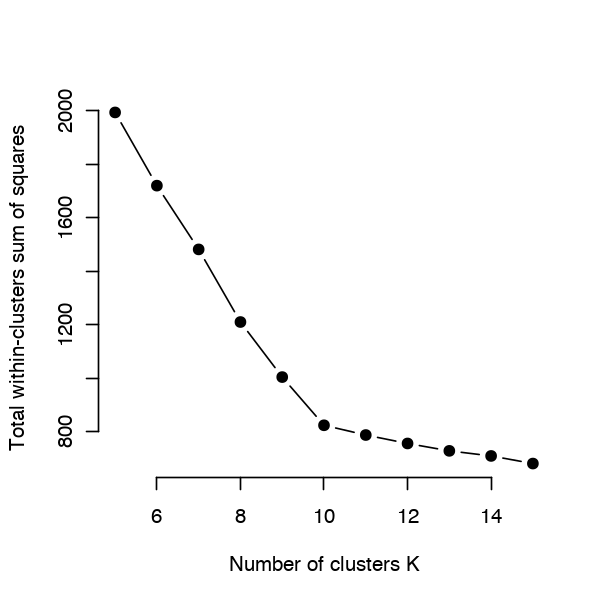

In [6]:
## cluster observations
set.seed(1981)
options(repr.plot.width=5, repr.plot.height=5)
wss <- sapply(5:15,
              function(k)
              {kmeans(som.model$codes[[1]],
                      k,
                      nstart=50)$tot.withinss
              })

plot(5:15, wss,
     type="b", pch = 19, frame = FALSE,
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares")

And I must admit that it is rare to find a case where the number of clusters suggested by this technique is so clear. So 10 will be...

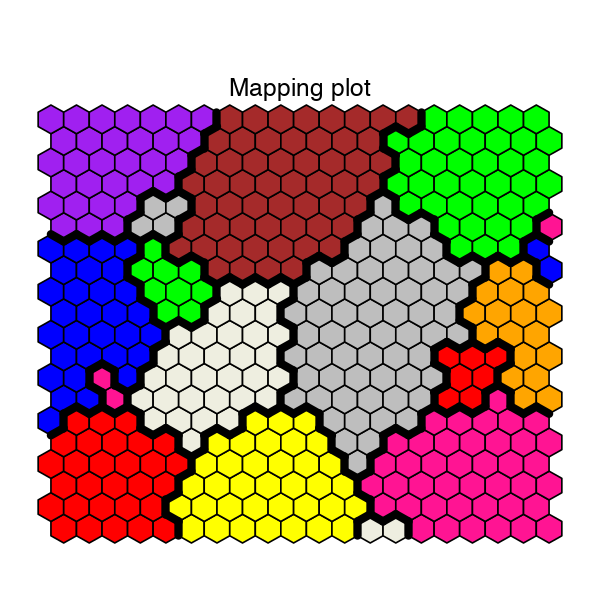

In [18]:
colorp <- c("red","blue","green","yellow","orange","purple",
            "deeppink","brown","grey","ivory2")
som.kclust <- kmeans(som.model$codes[[1]], 10)
plot(som.model,
     type="mapping",
     bgcol = colorp[som.kclust$cluster],
     labels = "",
     shape="straight")
add.cluster.boundaries(som.model, som.kclust$cluster)

here blue is clearly related to space-science topics (see the map for `topic_10` above). Note that if you run this again, you will obtain a different clustering colors (but mostly the same clustering structure). Just `set.seed()` before.

And finally, semantic fingerprint of a user that is interested in space-science related documents:

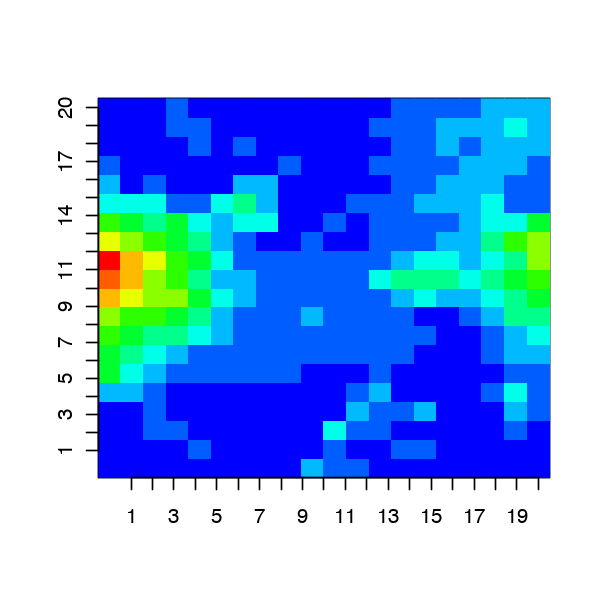

In [11]:
## semantic fingerprints

# Extract obervations for 3 random news articles that are classified as space-science 
doc.class <- read.csv("data_processed/document_class.txt")
sci.idx <- which(doc.class == "sci.space")
sci.docs <- sample(sci.idx, 3)
sci.docs.topics <- topic.mtx[sci.docs,]
sci.docs.X <-  X[sci.docs,]

# build a user profile by averaging
user.profile <- apply(sci.docs.X, 2, mean)

# get the weights and project the user onto the map
weights <- t(som.model$codes[[1]])
proj <- user.profile %*% weights

# build the matrix
dim = 20
proj.mtx <- matrix(0, dim, dim)
counter <- 0
counter.list <- list()
for (i in 1:dim)
{
    for (j in 1:dim)
    {
        proj.mtx[i,j] = proj[((i*dim)-dim)+j]
        counter = counter + 1
        coord <- c(i,j,counter)
        counter.list <- append(counter.list, list(coord))
    }
}

image(t(proj.mtx), xaxt='n', yaxt = "n", col = coolBlueHotRed(12))
axis(1, at = seq(0.05,1,0.05), labels = seq(1, dim, 1))
axis(2, at = seq(0.05,1,0.05), labels = seq(1, dim, 1))

and vualá, as expected, the fingerprint is almost identical to the map corresponding to topic_7 which dominates sci-space documents. 